To begin with project, the dataset is preprocessed and cleaned in such a way for exploratory analysis. Dataset used for this project is from MovieLens website. The GroupLens Research Project did clean up and wrote accompanying scripts for data. There are 45,000 metadata information of movies, which is used for primary exploratory analysis. The notebook contains complete code snippets for data preprocessing followed by data analysis with interesting visualiations.

In [51]:
# Import libraries
import pandas as pd
import numpy as np
import preprocessingfunc
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from ast import literal_eval

### Read Dataset

In [52]:
movies = pd.read_csv("themoviedataset/movies_metadata.csv")
movies.head()

C:\Users\HP\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


### Cleaning dataset

In [53]:
movies = movies.drop_duplicates(keep='first')

In [54]:
movies.dropna(how="all",inplace=True)

#### Missing values of status are filled with most frequent values, for runtime mean values are filled

In [55]:
movies["status"].fillna(movies["status"].value_counts().idxmax(), inplace=True)
movies["runtime"] = movies["runtime"].replace(0, np.nan)
movies["runtime"].fillna(movies["runtime"].mean(), inplace=True) 

In [56]:
movies.dropna(subset=["release_date"],inplace=True)
movies.dropna(subset=["original_language"],inplace=True)

In [57]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

#### Adding keyword column to dataframe

In [58]:
keywords = pd.read_csv('themoviedataset/keywords.csv')

In [59]:

movies['id'] = movies['id'].apply(preprocessingfunc.clean_ids)
movies = movies[movies['id'].notnull()]

In [60]:
movies['id'] = movies['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')
movies = movies.merge(keywords, on='id')

In [61]:
movies["keywords"] = movies["keywords"].apply(literal_eval)

In [62]:
#Extracting keywords from keywords in csv table
movies['keywords'] = movies['keywords'].apply(preprocessingfunc.generate_list)

#### Adding and preprocessing cast column to dataframe

In [63]:
credits = pd.read_csv("themoviedataset/credits.csv")

In [64]:
credits['id'] = credits['id'].astype('int')
movies = movies.merge(credits, on='id')

In [65]:
movies["cast"] = movies["cast"].apply(literal_eval)
movies["cast"] = movies["cast"].apply(preprocessingfunc.generate_list)

#### Preprocessing Production Companies column

In [66]:
movies["production_companies"] = movies["production_companies"].apply(literal_eval)
movies["production_companies"] = movies["production_companies"].apply(preprocessingfunc.generate_list)

#### Preprocessing Production countries column

In [67]:
movies["production_countries"] = movies["production_countries"].apply(literal_eval)
movies["production_countries"] = movies["production_countries"].apply(preprocessingfunc.generate_list)

### Extracting director column from crew 

In [68]:
movies['crew'] = movies['crew'].apply(literal_eval)

In [69]:
movies['crew'] = movies['crew'].apply(preprocessingfunc.extract_director)

In [70]:
movies = movies.rename(columns={"crew": "director"})

#### Dropping unwanted columns from dataframe

In [71]:
drop_df = ["homepage", "poster_path", "video", "imdb_id", "overview", 
           "spoken_languages", "tagline","adult","belongs_to_collection"]
movies.drop(drop_df, axis=1,inplace=True)

#### Extracting Release month and day from release_date column

In [72]:
movies['release_date'] = movies['release_date'].astype('datetime64[ns]')

In [73]:
movies['release_year'] = movies['release_date'].dt.year
movies['release_month'] = movies['release_date'].dt.month
movies['release_day'] = movies['release_date'].dt.day_name()

In [74]:
movies.drop(['release_date','original_title'], axis=1,inplace=True)

In [75]:
movies = movies[['title','genres','keywords','original_language','release_day','release_month',
                 'release_year','cast','director','budget','revenue','id','popularity','vote_average',
                 'vote_count','production_companies','production_countries','runtime',
                 'status']]

#### Datatype conversion of some columns

In [76]:
movies["popularity"] = movies["popularity"].astype(float)
movies["budget"] = movies["budget"].astype(float)

#### Preprocessing and normalizing budget and revenue column

In [77]:
movies['budget'] = movies['budget'].replace(0 , pd.np.nan)
movies['revenue'] = movies['revenue'].replace(0 , pd.np.nan)

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """Entry point for launching an IPython kernel.
C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [78]:
movies[['budget', 'revenue']] = movies[['budget', 'revenue']].applymap(preprocessingfunc.scale_money)

In [79]:
movies["profit"] = movies["revenue"] - movies["budget"]

#### As US dollar was inflated after 2010, the column with US dollar values have to be normalized.

In [80]:
min_val = movies["budget"].min()
max_val = movies["budget"].max()
movies[["budget", "revenue", "profit"]] = movies[["budget", "revenue", "profit"]].apply(lambda x: 
                                                            x / (max_val - min_val))

#### Making use of weighted average from statistical concept helps in ranking popular movies with the features vote count and vote average

In [82]:
vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.75)
def weighted_rating(data):
    v = data['vote_count'] + 1 # added +1
    R = data['vote_average']
    return (v / (v + m) * R) + (m / (m + v) * C)

movies['weighted_rating'] = movies.apply(weighted_rating, axis=1)

In [83]:
movies.drop(movies[(movies["cast"].isna())&(movies["director"].isna())].index, inplace=True)

### Exploratory Data Analysis

Dataset with null values are removed, some features (keywords, cast and crew information of each movies) are added from other csv file, feature engineering like normalization of gross, revenue and budget values, and weighted rating are done. Now we are good to go for EDA with cleaned dataset. 

#### Histogram plot of released movies based on genres 

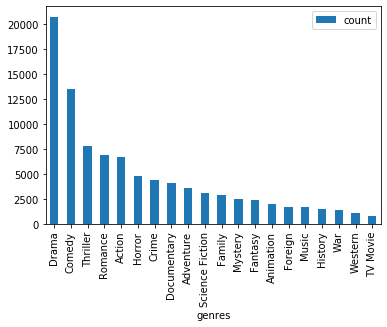

In [84]:
genres_occur = preprocessingfunc.list_counter(movies["genres"].values, log=False)
genres = pd.DataFrame.from_records(genres_occur, columns=["genres", "count"])
genres.plot(kind = 'bar', x="genres")

#### Histogram plot of movies released by countires

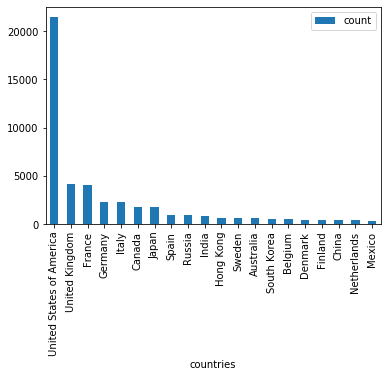

In [85]:
countries_occur = preprocessingfunc.list_counter(movies["production_countries"].values, log=False)
countries = pd.DataFrame.from_records(countries_occur, columns=["countries", "count"])
countries.head(20).plot(kind = 'bar', x="countries")

#### Histogram of movies released by production companies

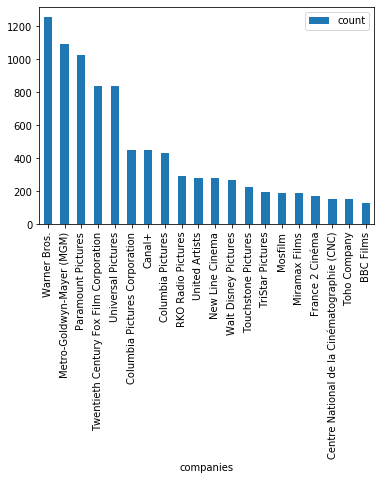

In [86]:
companies_occur = preprocessingfunc.list_counter(movies["production_companies"].values, log=False)
companies = pd.DataFrame.from_records(companies_occur, columns=["companies", "count"])
companies.head(20).plot(kind = 'bar', x="companies")

#### Top 10 rated films

In [88]:
movies.sort_values('weighted_rating', ascending=False)[["title", "director", "genres", "profit", 
                                                    "popularity", "weighted_rating",'release_year']].head(10)

,title,director,genres,profit,popularity,weighted_rating,release_year
10380,Dilwale Dulhania Le Jayenge,Aditya Chopra,"[Comedy, Drama, Romance]",0.228427,34.457024,8.911640,1995
314,The Shawshank Redemption,Frank Darabont,"[Drama, Crime]",0.008794,51.645403,8.486811,1994
835,The Godfather,Francis Ford Coppola,"[Drama, Crime]",0.629139,41.109264,8.481730,1972
41290,Your Name.,Makoto Shinkai,"[Romance, Animation, Drama]",NaN,34.461252,8.396057,2016
12572,The Dark Knight,Christopher Nolan,"[Drama, Action, Crime, Thriller]",2.156790,123.167259,8.291556,2008
2864,Fight Club,David Fincher,[Drama],0.099618,63.869599,8.289303,1999
292,Pulp Fiction,Quentin Tarantino,"[Thriller, Crime]",0.541932,140.950236,8.288064,1994
522,Schindler's List,Steven Spielberg,"[Drama, History, War]",0.787825,41.725123,8.276762,1993
23781,Whiplash,Damien Chazelle,[Drama],0.025769,64.299990,8.276446,2014
5521,Spirited Away,Hayao Miyazaki,"[Fantasy, Adventure, Animation, Family]",0.684031,41.048867,8.274045,2001


#### Top 10 Popular films

In [89]:
movies.sort_values('popularity', ascending=False)[["title", "director", "genres", "profit", 
                                                    "popularity", "weighted_rating",'release_year']].head(100)

,title,director,genres,profit,popularity,weighted_rating,release_year
30816,Minions,Kyle Balda,"[Family, Animation, Adventure, Comedy]",2.849367,547.488298,6.391751,2015
33469,Wonder Woman,Patty Jenkins,"[Action, Adventure, Fantasy]",1.767363,294.337037,7.186858,2017
43250,Beauty and the Beast,Bill Condon,"[Family, Fantasy, Romance]",2.902409,287.253654,6.790494,2017
44665,Baby Driver,Edgar Wright,"[Action, Crime]",0.501359,228.032744,7.168603,2017
24568,Big Hero 6,Chris Williams,"[Adventure, Family, Animation, Action, Comedy]",1.281890,213.849907,7.786259,2014
...,...,...,...,...,...,...,...
23574,Edge of Tomorrow,Doug Liman,"[Action, Science Fiction]",0.506701,31.982986,7.584025,2014
42182,The Autopsy of Jane Doe,André Øvredal,"[Horror, Mystery]",NaN,31.772396,6.256956,2016
25501,The Hobbit: The Battle of the Five Armies,Peter Jackson,"[Action, Adventure, Fantasy]",1.857996,31.718977,7.087172,2014
26680,Star Wars: The Force Awakens,J.J. Abrams,"[Action, Adventure, Science Fiction, Fantasy]",4.798083,31.626013,7.490446,2015


#### Top 10 grossing films of all time

In [90]:
movies.sort_values('profit', ascending=False)[["title", "director", "genres", "profit", 
                                                    "popularity", "weighted_rating"]].head(10)

,title,director,genres,profit,popularity,weighted_rating
14675,Avatar,James Cameron,"[Action, Adventure, Fantasy, Science Fiction]",6.713243,185.070892,7.194526
26680,Star Wars: The Force Awakens,J.J. Abrams,"[Action, Adventure, Science Fiction, Fantasy]",4.798083,31.626013,7.490446
1653,Titanic,James Cameron,"[Drama, Romance, Thriller]",4.329151,26.889070,7.490173
25195,Jurassic World,Colin Trevorrow,"[Action, Adventure, Science Fiction, Thriller]",3.588328,32.790475,6.495190
28953,Furious 7,James Wan,[Action],3.463905,27.275687,7.283699
17947,The Avengers,Joss Whedon,"[Science Fiction, Action, Adventure]",3.419979,89.887648,7.393910
17566,Harry Potter and the Deathly Hallows: Part 2,David Yates,"[Family, Fantasy, Adventure]",3.202716,24.990737,7.885379
26683,Avengers: Age of Ultron,Joss Whedon,"[Action, Adventure, Science Fiction]",2.961667,37.379420,7.289932
22223,Frozen,Chris Buck,"[Animation, Adventure, Family]",2.958549,24.248243,7.287233
43250,Beauty and the Beast,Bill Condon,"[Family, Fantasy, Romance]",2.902409,287.253654,6.790494


#### Years with most number of movie release

In [91]:
num_movies_released = pd.DataFrame(movies['release_year'].value_counts())
num_movies_released.head(10)

,release_year
2014,2057
2015,2041
2013,1949
2012,1786
2011,1722
2016,1675
2009,1625
2010,1539
2008,1511
2007,1342


#### Analysing data based on movie genres

In [42]:
def list_to_col(data, col_name, col_list, limiter = 9999):
    counter = 0
    selected_items = set()
    for item in col_list:
        if counter >= limiter:
            break
        item = item[0]
        data[item] = 0
        selected_items.add(item)
        counter += 1
    
    for index, row in data.iterrows():
        for item in row[col_name]:  
            if item in selected_items:
                data.at[index, item] = 1
    data.drop([col_name], axis=1, inplace=True)
    return data

#### Creating new columns by splitting array of values in genre columns

#### Splitting list of genre values to seprate columns

In [92]:
movies_genres = movies[["title", "genres", "popularity", "budget", "revenue" , "vote_count", "weighted_rating"]]
genres = preprocessingfunc.list_counter(movies_genres["genres"].values, log=False)


In [93]:
movies_genres = preprocessingfunc.list_to_col(movies_genres, "genres", genres)
movies_genres

C:\Users\HP\Documents\Data mining\preprocessingfunc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[item] = 0


,title,popularity,budget,revenue,vote_count,weighted_rating,Drama,Comedy,Thriller,Romance,...,Family,Mystery,Fantasy,Animation,Foreign,Music,History,War,Western,TV Movie
0,Toy Story,21.946943,0.078949,0.983063,5415.0,7.684679,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,Jumanji,17.015539,0.171057,0.691590,2413.0,6.877002,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
2,Grumpier Old Men,11.712900,NaN,NaN,92.0,6.163789,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Waiting to Exhale,3.859495,0.042106,0.214353,34.0,5.678278,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Father of the Bride Part II,8.387519,NaN,0.201529,173.0,5.625486,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46462,Robin Hood,5.683753,NaN,NaN,26.0,5.445921,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
46463,Century of Birthing,0.178241,NaN,NaN,3.0,5.639504,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46464,Betrayal,0.903007,NaN,NaN,6.0,4.997589,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
46465,Satan Triumphant,0.003503,NaN,NaN,0.0,5.094319,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Transforming into dataframe with information like average popularity, budget, vote_count, rating of all films based on genres

In [94]:
movies_means_genres = preprocessingfunc.binary_mean_dataset_generator(movies_genres, genres)
movies_means_genres['profit'] = movies_means_genres['revenue'] - movies_means_genres['budget']


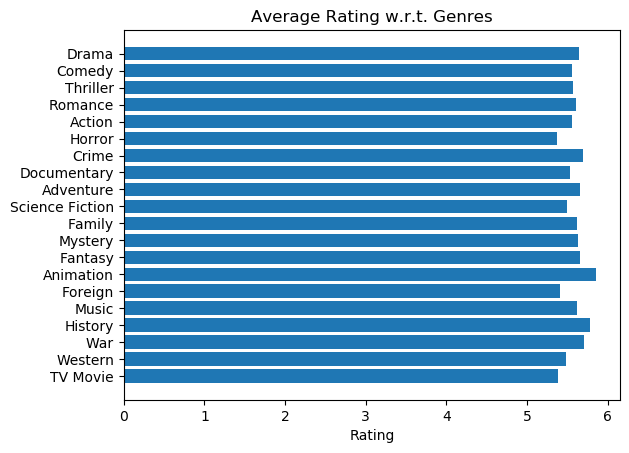

In [95]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(movies_means_genres))
ax.barh(y_pos, movies_means_genres['rating'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(movies_means_genres['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rating')
ax.set_title('Average Rating w.r.t. Genres')
plt.show()

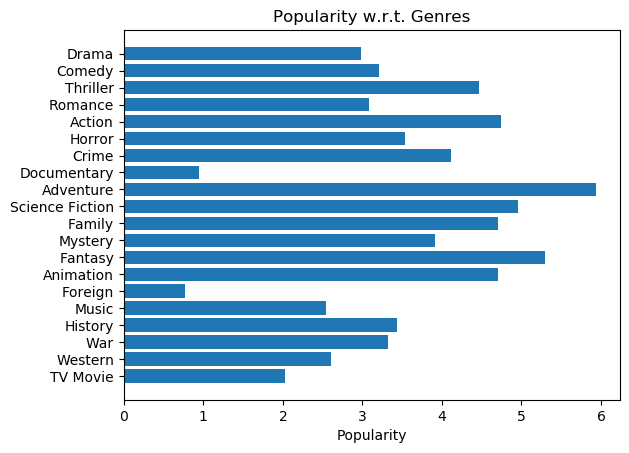

In [96]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(movies_means_genres))
ax.barh(y_pos, movies_means_genres['popularity'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(movies_means_genres['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('Popularity w.r.t. Genres')
plt.show()

#### Top grossing genres

In [97]:
movies_means_genres.sort_values('profit', ascending=False)[["type", "popularity",'budget', 'revenue', 'vote_count', 'rating',
       'profit']].head(10)

,type,popularity,budget,revenue,vote_count,rating,profit
13,Animation,4.709260,0.122974,0.455111,233.058438,5.857863,0.332137
8,Adventure,5.940254,0.133804,0.464071,403.480871,5.662074,0.330266
12,Fantasy,5.293885,0.123166,0.427393,325.288178,5.650708,0.304227
10,Family,4.710086,0.122115,0.412428,240.310357,5.624515,0.290313
9,Science Fiction,4.950465,0.092749,0.339545,316.569231,5.493809,0.246796
4,Action,4.738868,0.096710,0.305010,255.957862,5.556673,0.208299
2,Thriller,4.462024,0.061591,0.181591,186.376465,5.566651,0.120000
1,Comedy,3.214611,0.057273,0.169411,108.333209,5.558972,0.112138
11,Mystery,3.908183,0.058737,0.166436,163.041667,5.630955,0.107699
17,War,3.318691,0.064316,0.168601,118.920505,5.710623,0.104285


#### Top 10 genres sorted by popularity

In [98]:
movies_means_genres.sort_values('popularity', ascending=False)[["type", "popularity",'budget', 'revenue', 'vote_count', 'rating',
       'profit']].head(10)

,type,popularity,budget,revenue,vote_count,rating,profit
8,Adventure,5.940254,0.133804,0.464071,403.480871,5.662074,0.330266
12,Fantasy,5.293885,0.123166,0.427393,325.288178,5.650708,0.304227
9,Science Fiction,4.950465,0.092749,0.339545,316.569231,5.493809,0.246796
4,Action,4.738868,0.096710,0.305010,255.957862,5.556673,0.208299
10,Family,4.710086,0.122115,0.412428,240.310357,5.624515,0.290313
13,Animation,4.709260,0.122974,0.455111,233.058438,5.857863,0.332137
2,Thriller,4.462024,0.061591,0.181591,186.376465,5.566651,0.120000
6,Crime,4.117936,0.058210,0.153513,174.160922,5.696820,0.095303
11,Mystery,3.908183,0.058737,0.166436,163.041667,5.630955,0.107699
5,Horror,3.539796,0.025149,0.110491,99.919857,5.369752,0.085342


<Figure size 1200x900 with 0 Axes>

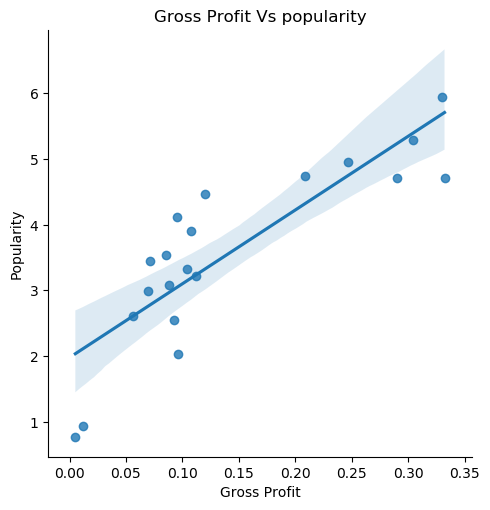

In [99]:
plt.figure(figsize = (12,9));
sns.lmplot(x = 'profit' , y = 'popularity', data = movies_means_genres);
plt.xlabel('Gross Profit');
plt.ylabel('Popularity');
plt.title('Gross Profit Vs popularity');

It is clear that there is some correlation between gross and popularity from plots and top 10 genres sorted by popularity and gross table.

#### Money spent on making films based on genres (Top 10)

In [100]:
movies_means_genres.sort_values('budget', ascending=False)[["type", "popularity",'budget', 'revenue', 'vote_count', 'rating',
       'profit']].head(10)

,type,popularity,budget,revenue,vote_count,rating,profit
8,Adventure,5.940254,0.133804,0.464071,403.480871,5.662074,0.330266
12,Fantasy,5.293885,0.123166,0.427393,325.288178,5.650708,0.304227
13,Animation,4.709260,0.122974,0.455111,233.058438,5.857863,0.332137
10,Family,4.710086,0.122115,0.412428,240.310357,5.624515,0.290313
4,Action,4.738868,0.096710,0.305010,255.957862,5.556673,0.208299
9,Science Fiction,4.950465,0.092749,0.339545,316.569231,5.493809,0.246796
17,War,3.318691,0.064316,0.168601,118.920505,5.710623,0.104285
16,History,3.440845,0.061812,0.133289,106.492632,5.786493,0.071477
2,Thriller,4.462024,0.061591,0.181591,186.376465,5.566651,0.120000
18,Western,2.609241,0.060370,0.116661,74.591682,5.481333,0.056292


#### Analysing data based on country of release

The analysis is started by following same data preprocessing routine from previous section.

In [101]:
movies_countries = movies[["title", "production_countries", "popularity", "budget", "revenue", "vote_count", "weighted_rating"]]
countries = preprocessingfunc.list_counter(movies_countries["production_countries"].values, limiter=20, log=False)
movies_countries = preprocessingfunc.list_to_col(movies_countries, "production_countries", countries, 20)
movies_means_ct = preprocessingfunc.binary_mean_dataset_generator(movies_countries, countries)


C:\Users\HP\Documents\Data mining\preprocessingfunc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[item] = 0


In [102]:
movies_means_ct['profit'] =movies_means_ct['revenue'] - movies_means_ct['budget']

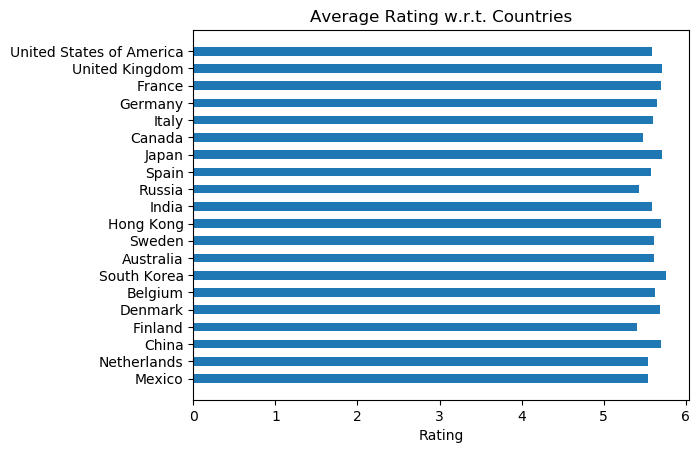

In [103]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(movies_means_ct))
ax.barh(y_pos, movies_means_ct['rating'], height=0.5, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(movies_means_ct['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rating')
ax.set_title('Average Rating w.r.t. Countries')
plt.show()

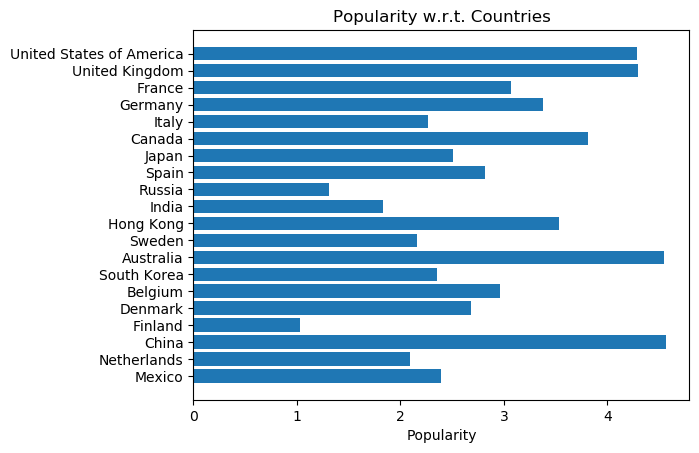

In [104]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(movies_means_ct))
ax.barh(y_pos, movies_means_ct['popularity'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(movies_means_ct['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('Popularity w.r.t. Countries')
plt.show()

#### Top grossing films averaged by countries

In [105]:
movies_means_ct.sort_values('profit', ascending=False)[["type", "popularity",'budget', 'revenue', 'vote_count', 'rating',
       'profit']]

,type,popularity,budget,revenue,vote_count,rating,profit
17,China,4.563943,0.099785,0.319079,202.117949,5.700421,0.219294
0,United States of America,4.282193,0.072160,0.222914,199.904101,5.584986,0.150755
1,United Kingdom,4.294910,0.070929,0.211261,187.298464,5.710545,0.140332
12,Australia,4.544579,0.082777,0.208430,209.453287,5.615894,0.125653
3,Germany,3.377251,0.073747,0.185254,143.178943,5.657689,0.111507
5,Canada,3.814899,0.051302,0.150792,133.543478,5.481107,0.099490
6,Japan,2.504420,0.053132,0.151275,60.944348,5.713598,0.098143
10,Hong Kong,3.534380,0.071616,0.148843,96.026667,5.704970,0.077226
16,Finland,1.029739,0.009850,0.077688,17.186398,5.412990,0.067838
19,Mexico,2.392378,0.028786,0.076448,61.466077,5.545984,0.047663


#### Analysing based on keywords

In [106]:
df_key = movies[["title", "keywords", "popularity", "budget", "revenue", "vote_count", "weighted_rating"]]
df_key.dropna(subset=["keywords"], inplace=True)
keywords = preprocessingfunc.list_counter(df_key["keywords"].values, 20, log=False)
df_key = preprocessingfunc.list_to_col(df_key, "keywords", keywords)
df_means_key = preprocessingfunc.binary_mean_dataset_generator(df_key, keywords, 20)


C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\HP\Documents\Data mining\preprocessingfunc.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[item] = 0


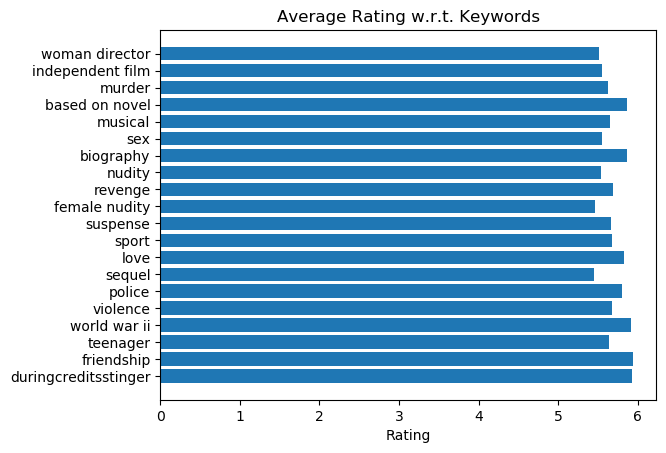

In [107]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(df_means_key))
ax.barh(y_pos, df_means_key['rating'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_means_key['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Rating')
ax.set_title('Average Rating w.r.t. Keywords')
plt.show()

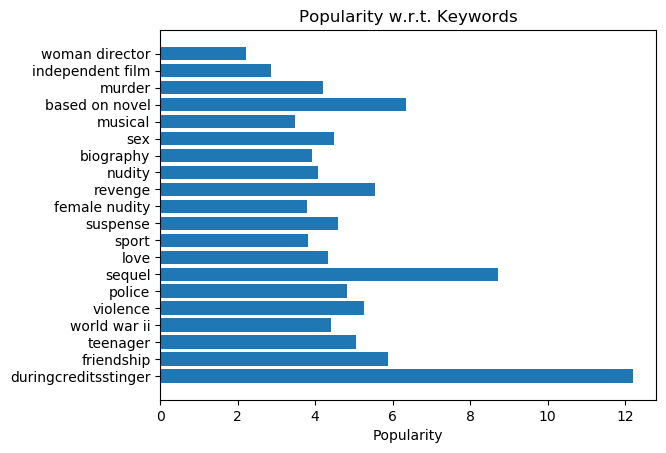

In [108]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(df_means_key))
ax.barh(y_pos, df_means_key['popularity'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_means_key['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Popularity')
ax.set_title('Popularity w.r.t. Keywords')
plt.show()

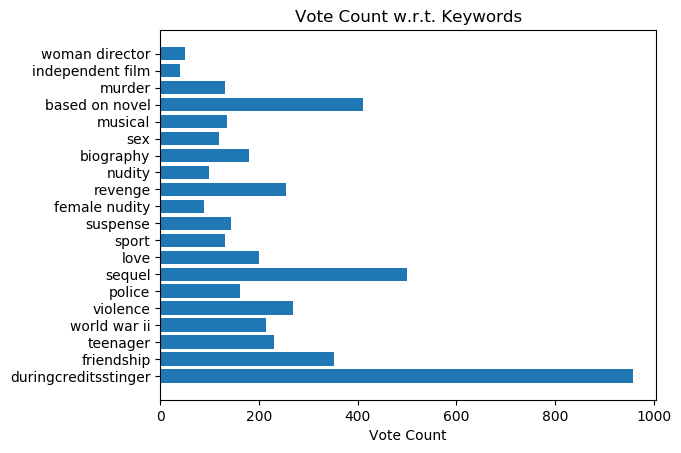

In [109]:
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(df_means_key))
ax.barh(y_pos, df_means_key['vote_count'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_means_key['type'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Vote Count')
ax.set_title('Vote Count w.r.t. Keywords')
plt.show()

In [110]:
df_means_key['profit'] = df_means_key['revenue'] - df_means_key['budget']

In [111]:
df_means_key.sort_values('profit', ascending=False)[["type", "popularity",'budget', 'revenue', 'vote_count', 'rating',
       'profit']]

,type,popularity,budget,revenue,vote_count,rating,profit
13,sequel,8.717537,0.136719,0.557633,499.750583,5.445558,0.420915
19,duringcreditsstinger,12.197066,0.129922,0.436964,957.233618,5.931705,0.307042
3,based on novel,6.344666,0.090544,0.285138,410.375598,5.863886,0.194595
4,musical,3.492114,0.064966,0.253746,136.292181,5.649259,0.188780
18,friendship,5.889505,0.065397,0.210631,351.696000,5.933119,0.145234
10,suspense,4.582490,0.049526,0.175312,143.594643,5.657707,0.125787
16,world war ii,4.409237,0.073062,0.198290,215.093909,5.916174,0.125227
8,revenge,5.554386,0.062347,0.186785,254.722222,5.683480,0.124438
15,violence,5.274340,0.050600,0.171848,269.009662,5.680336,0.121248
12,love,4.340484,0.047027,0.139678,199.421348,5.821924,0.092651


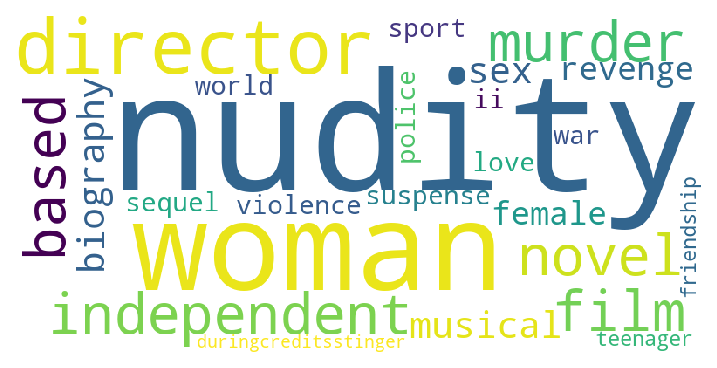

In [112]:
plt.figure(figsize = (9,9))
stopwords = set(STOPWORDS)
tagline_cloud = WordCloud(width=800, height=400,background_color="white",max_words=30,stopwords=stopwords).generate(' '.join(df_means_key['type']))

# Generate plot

plt.axis("off")
plt.imshow(tagline_cloud)
plt.show()

In this notebook, the information on data preprocessing are discussed. Also, there are interesting insights gained from dataset after cleaning and employing appropriate feature extraction. Furthermore, the project mainly focuses on the model used in building a recommendation system for movies to suggest users. The code snippets of recommender system is explained in another notebook file. 